# Model

**Input:**
*   target Names: list of names to be checked
*  flagged names: list of flagged names


**Output:**
*   List of names which matched/were similar to any name in flagged names list

**Steps for processing a pair of strings:**
1.  remove honorifics if any - Dr., Mr., etc. + check for exact match
2. check if any string has initials
3. calculate similarity score - Levenshtein Distance, Jaro winkler, etc
4. if score is below threshold, check phonetic similarity - use both soundex and double metaphone

Notebooks to create
* A. 1 + 3 -- includes comparison betweeen similarity algo
* B. 1 + 3+ 4
* C. 1 +2+3+4
* D. 1 +2+3+4 + handle  out of order components ( Name -James Nathaniel Davis, reordered - James Nathaniel Davis, Davis James Nathaniel)
* Final. entire model





# Approach 1: Levenshtein Distance



---
TODO: compare this step with
* Jaccard Similarity/N-grams
* Cosine similarity
* Jaro Winkler



In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.9 MB/s eta 0:00:00


In [ ]:


def levenshtein_distance(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    # Initialize the matrix for dynamic programming
    dp = [[0] * (len_s2 + 1) for _ in range(len_s1 + 1)]

    # Fill the base cases for transforming from/to empty string
    for i in range(len_s1 + 1):
        dp[i][0] = i
    for j in range(len_s2 + 1):
        dp[0][j] = j

    # Compute distances with insertions, deletions, and substitutions
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            if s1[i - 1] == s2[j - 1]:  # If characters match
                dp[i][j] = dp[i - 1][j - 1]
            else:  # Minimum of insertions, deletions, and substitutions
                dp[i][j] = min(dp[i - 1][j] + 1,   # Deletion
                               dp[i][j - 1] + 1,   # Insertion
                               dp[i - 1][j - 1] + 1)  # Substitution
    return dp[len_s1][len_s2]


def normalized_similarity(s1, s2):
    lev_distance = levenshtein_distance(s1, s2)
    max_len = max(len(s1), len(s2))
    if max_len == 0:  # Avoid division by zero
        return 100
    similarity_score = (1 - lev_distance / max_len) * 100
    return round(similarity_score, 2)

In [ ]:
import Levenshtein

print(normalized_similarity('Catherine','Kathryn'))
print(Levenshtein.ratio('Catherine','Kathryn'))
print(Levenshtein.jaro_winkler('Catherine','Kathryn'))
print(Levenshtein.jaro('Catherine','Kathryn'))

55.56
0.625
0.7566137566137566
0.7566137566137566


In [ ]:
def partial_ratio(s1, s2):
    # Ensure s1 is the shorter or equal-length string for efficiency
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    highest_similarity = 0
    len_s1 = len(s1)

    # Slide a window of len(s1) over s2
    for i in range(len(s2) - len_s1 + 1):
        substring = s2[i:i + len_s1]
        similarity = normalized_similarity(s1, substring)
        highest_similarity = max(highest_similarity, similarity)

    return highest_similarity

In [ ]:
partial_ratio("Akash Verma", "Verma Akash")

9.09

In [ ]:
import pandas as pd
df = pd.read_csv('/content/sample_data/name-matching - Sheet1 (1).csv')

In [ ]:
df

,text1,text2,label
0,akash,akas,1
1,akash r verma,akash rajan verma,1
2,akasj,vijas,0
3,rajan,verma,0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define threshold for classification
similarity_threshold = 75  # Adjust this based on your needs

# Calculate similarity scores and predict labels
df['Similarity_Score'] = df.apply(lambda row: normalized_similarity(row['text1'], row['text2']), axis=1)
df['Predicted_Label'] = df['Similarity_Score'].apply(lambda score: 1 if score >= similarity_threshold else 0)


In [ ]:
df


,text1,text2,label,Similarity_Score,Predicted_Label
0,akash,akas,1,80.00,1
1,akash r verma,akash rajan verma,1,76.47,1
2,akasj,vijas,0,20.00,0
3,rajan,verma,0,0.00,0


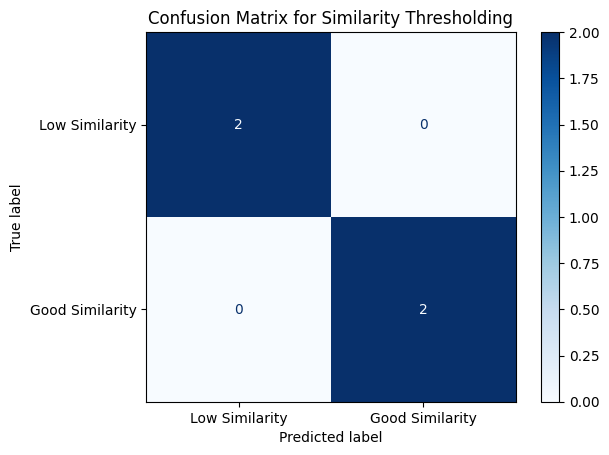

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [ ]:
# Actual vs Predicted labels
y_true = df['label']
y_pred = df['Predicted_Label']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Similarity', 'Good Similarity'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Similarity Thresholding")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))


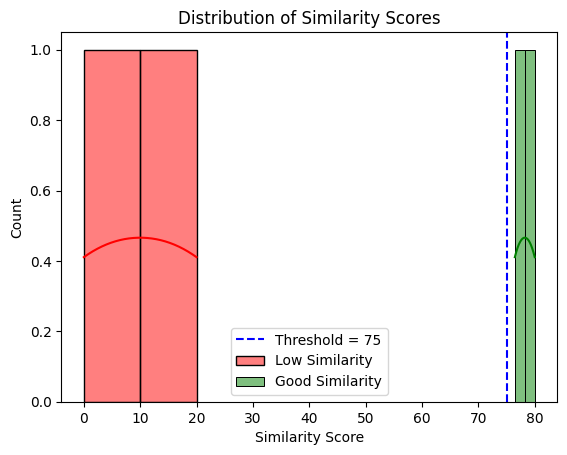

In [ ]:
sns.histplot(df[df['label'] == 0]['Similarity_Score'], color='red', label='Low Similarity', kde=True)
sns.histplot(df[df['label'] == 1]['Similarity_Score'], color='green', label='Good Similarity', kde=True)
plt.axvline(x=similarity_threshold, color='blue', linestyle='--', label=f'Threshold = {similarity_threshold}')
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.legend()
plt.show()


                 text1             text2  label
0        jerry edwards     jarry edwards      1
1        jerry edwards    gerrie edwards      1
2        jarry edwards    jerrie edwards      1
3        edwards jarry    jerrie edwards      1
4         jesus christ     Jesuss christ      1
5           bill smith      will a smith      1
6          billy smith    wil ly a smith      1
7          billy smith      wil ly smyth      1
8       Catherine Karo     KathrynCarrol      1
9               Gerrad             jerad      1
10          Marry Elen         MaryEllen      1
11           MarryElen        Mary-Ellen      1
12       Abdul Rasheed     Abd al-Rashid      1
13     Rip. Van Winkle  Rip Wan . Vinkle      1
14  Philip Charles Car       Philip Carl      1


                 text1             text2  label  Similarity_Score  \
0        jerry edwards     jarry edwards      1             92.31   
1        jerry edwards    gerrie edwards      1             78.57   
2        jarry edwards 

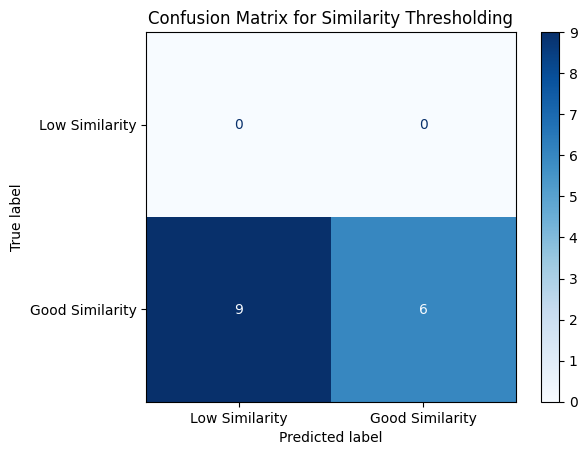



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.40      0.57        15

    accuracy                           0.40        15
   macro avg       0.50      0.20      0.29        15
weighted avg       1.00      0.40      0.57        15



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd

dataset =[
    ['jerry edwards', 'jarry edwards', 1],
    ['jerry edwards', 'gerrie edwards', 1],
    ['jarry edwards', 'jerrie edwards', 1],
    ['edwards jarry', 'jerrie edwards', 1],
    ['jesus christ', 'Jesuss christ', 1],
    ['bill smith', 'will a smith', 1],
    ['billy smith', 'wil ly a smith', 1],
    ['billy smith', 'wil ly smyth', 1],
    ['Catherine Karo', 'KathrynCarrol', 1],
    ["Gerrad", "jerad", 1],
    ['Marry Elen', 'MaryEllen', 1],
    ['MarryElen', 'Mary-Ellen', 1],
    ['Abdul Rasheed', 'Abd al-Rashid', 1],
    ['Rip. Van Winkle', 'Rip Wan . Vinkle', 1],
    ['Philip Charles Car', 'Philip Carl', 1],
]
df = pd.DataFrame(dataset, columns =['text1', 'text2', 'label'])


print(df)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define threshold for classification
similarity_threshold = 75  # Adjust this based on your needs

# Calculate similarity scores and predict labels
df['Similarity_Score'] = df.apply(lambda row: normalized_similarity(row['text1'], row['text2']), axis=1)
df['Predicted_Label'] = df['Similarity_Score'].apply(lambda score: 1 if score >= similarity_threshold else 0)

print('\n')
print(df)
print('\n')

# Actual vs Predicted labels
y_true = df['label']
y_pred = df['Predicted_Label']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Similarity', 'Good Similarity'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Similarity Thresholding")
plt.show()

# Classification Report
print('\n')
print(classification_report(y_true, y_pred))



In [ ]:
partial_ratio('Philip Charles Car', 'Philip Carl')

81.82

## Phonetic similarity

In [ ]:
!pip install phonetics
!pip install Metaphone

  Preparing metadata (setup.py) ... done
  Created wheel for phonetics: filename=phonetics-1.0.5-py2.py3-none-any.whl size=8696 sha256=57c33b52263d9245ae02cc1c524d7d0c04b50596bf07446964f210e5738d7a1d
  Stored in directory: /root/.cache/pip/wheels/b7/1e/82/80a78c7d1ad7fc6e0af1b4d9009360b251c0e50fe59f046edb
Successfully built phonetics
  Preparing metadata (setup.py) ... done
  Created wheel for Metaphone: filename=Metaphone-0.6-py3-none-any.whl size=13901 sha256=9a16e6e0fd2c1b933c28f2f16c64fb1e71e8f434f0b966d2508d5e9ab1af3dd0
  Stored in directory: /root/.cache/pip/wheels/23/dd/1d/6cdd346605db62bde1f60954155e9ce48f4681c243f265b704
Successfully built Metaphone


In [ ]:
import phonetics

def soundex_similarity(word1, word2):
    print(word1, phonetics.soundex(word1))
    print(word2, phonetics.soundex(word2))
    return phonetics.soundex(word1) == phonetics.soundex(word2)

# Example
print(soundex_similarity("Gerrad", "jerrad"))
print(soundex_similarity("Jesus", "Heyzeus"))
print(soundex_similarity("Jesussssssss", "Jeyzeus"))
print(soundex_similarity('RipVanWinkle', 'RipWanVinkle'))

Gerrad G0603
jerrad j0603
False
Jesus J0202
Heyzeus H0202
False
Jesussssssss J0202
Jeyzeus J0202
True
RipVanWinkle R0105205240
RipWanVinkle R01205105240
False


In [ ]:
from metaphone import doublemetaphone

def are_phonetically_similar(word1, word2):
  primary1, secondary1 = doublemetaphone(word1)
  primary2, secondary2 = doublemetaphone(word2)

  print(word1, primary1, secondary1)
  print(word2, primary2, secondary2)

  return (primary1 == primary2 or primary1 == secondary2 or secondary1 == primary2 or secondary1 == secondary2)

# Test for similarity
print(are_phonetically_similar("Gerrad", "jerrad"))
print(are_phonetically_similar("Jesussssssss", "Jeyzeus"))
print(are_phonetically_similar("Jeyzeus", "Haezoos"))
print(are_phonetically_similar("Abdul Rasheed", "Abd al rashid"))
print(are_phonetically_similar('Rip. Van Winkle', 'Rip Wan . Vinkle'))
print(are_phonetically_similar('Philip Charles Car', 'Philip Carl'))

print(phonetics.dmetaphone('Philip Charles Car'))

Gerrad KRT JRT
jerrad JRT ART
True
Jesussssssss JSSSSS ASSSSS
Jeyzeus JSS ASS
False
Jeyzeus JSS ASS
Haezoos HSS 
False
Abdul Rasheed APTLRXT 
Abd al rashid APTLRXT 
True
Rip. Van Winkle RPPFNNKL 
Rip Wan . Vinkle RPNNFNKL 
True
Philip Charles Car FLPXRLSKR FLPKRLSKR
Philip Carl FLPKRL 
False
('FLPXRLSKR', 'FLPKRLSKR')


In [ ]:
from itertools import product

def generate_name_variations(name):
    parts = name.split()
    variations = []

    # Generate both full and initial for each part
    parts_options = [[part, part[0]] for part in parts]

    # Get all combinations of full names and initials
    for combo in product(*parts_options):
        variations.append(" ".join(combo))

    return set(variations)

# Example usage
name = "Akash Rajan Verma"
name_variations = generate_name_variations(name)
print(name_variations)

{'Akash R V', 'Akash R Verma', 'Akash Rajan Verma', 'A Rajan V', 'Akash Rajan V', 'A R V', 'A Rajan Verma', 'A R Verma'}


In [ ]:
pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz

In [ ]:
fuzz.token_sort_ratio("Davis James Nathaniel",	"J N Davis")

60

In [ ]:
fuzz.token_sort_ratio("Abdul Rasheed",	"Xander Cooper")

51

In [ ]:
print(fuzz.token_sort_ratio('gbc gty james xyz', 'g gty j'))
print(fuzz.token_sort_ratio("Jesussssssss", "Jeyzeus"))
print(fuzz.token_sort_ratio("Jeyzeus", "Haezoos"))
print(fuzz.token_sort_ratio("Abdul Rasheed", "Abd al rashid"))
print(fuzz.token_sort_ratio('Rip. Van Winkle', 'Rip Wan . Vinkle'))
print(fuzz.token_sort_ratio('Philip Charles Car', 'Philip Carl'))

58
42
43
77
71
76


# KAGGLE DATA
https://www.kaggle.com/code/satishgunjal/dataframe-parallel-processing

NOTE: add test.csv from abov link to 'sample_data' folder

In [6]:
!pip install git+https://github.com/chrislit/abydos.git
# !pip install abydos
!pip install fuzzywuzzy
!pip install numpy
!pip install pandas

  Cloning https://github.com/chrislit/abydos.git to /tmp/pip-req-build-ha4glz40
  Running command git clone --filter=blob:none --quiet https://github.com/chrislit/abydos.git /tmp/pip-req-build-ha4glz40
  Resolved https://github.com/chrislit/abydos.git to commit 344346a5fceb6acc631b3d24e16b73a303cece2c
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
import pandas as pd
import numpy as np
import multiprocessing
from multiprocessing import Pool

In [8]:
from abydos.phones import *
from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95, MRA, Editex, SAPS, FlexMetric, JaroWinkler, Sift4, Eudex, Covington) #,HigueraMico, ALINE, PhoneticEditDistance)
from abydos.phonetic import PSHPSoundexFirst, Ainsworth
from fuzzywuzzy import fuzz

pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
sift4 = Sift4()
eudex = Eudex()
covington = Covington()

algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro,  sift4, eudex]
algo_names = ['Iterative Substring', 'Bisim', 'Discounted Levenshtein', 'Prefix', 'Lcsstr', 'Mlipns', 'Strcmp95', 'MRA', 'Editex', 'Saps', 'Flexmetric', 'Jaro',  'Sift4', 'Eudex']

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [9]:
def generate_full_name_similarity_score(name1, name2):
  similarity_scores = [0.0] * (len(algo_names) + 5)

  if(type(name1) == str and type(name2) == str and name1 != '' or name2 != ''):
    similarity_scores = []
    partial_score = (fuzz.partial_ratio(name1, name2))/100
    token_sort_score = (fuzz.token_sort_ratio(name1, name2))/100
    token_set_score = (fuzz.token_set_ratio(name1, name2))/100
    pshp_score = 0
    if(pshp_soundex_first.encode(name1) == pshp_soundex_first.encode(name2)):
      pshp_score = 1
    similarity_scores.extend([partial_score, token_sort_score, token_set_score, pshp_score])

    for i, algo in enumerate(algos):
      similarity_scores.append(algo.sim(name1, name2))

    fullname_similarity_score = sum(similarity_scores)/len(similarity_scores)
    similarity_scores.append(fullname_similarity_score)
  return similarity_scores

def predict_scores(df):
  score_cols = ["partial_score", "token_sort_score", "token_set_score", "pshp_score"] + algo_names + ["Overall score"]
  df[score_cols] = df.apply(lambda row: generate_full_name_similarity_score(row.Name1, row.Name2), axis=1, result_type='expand')
  return df

In [10]:
df = pd.read_csv('/content/sample_data/test.csv')
df1 = predict_scores(df)
df1.to_csv('/content/sample_data/test_output.csv')

In [11]:
df1.head()

,Record Id1,Record Id2,Name1,Name2,Label,partial_score,token_sort_score,token_set_score,pshp_score,Iterative Substring,...,Mlipns,Strcmp95,MRA,Editex,Saps,Flexmetric,Jaro,Sift4,Eudex,Overall score
0,1000,1000,stuti aayush agarwal,shuti aayush agarwal,1,0.95,0.95,0.95,0.0,0.947604,...,1.0,0.954211,0.666667,0.950,1.0,0.960,0.949123,0.95,0.905882,0.830352
1,1000,1000,stuti aayush agarwal,stuti agarwal,1,0.69,0.79,1.00,1.0,0.936364,...,0.0,0.899231,1.000000,0.775,1.0,0.735,0.832051,0.45,0.991667,0.743560
2,1000,1000,stuti aayush agarwal,stuti ayush agrawal,1,0.89,0.62,0.62,1.0,0.950192,...,0.0,0.937368,1.000000,0.900,0.5,0.905,0.895614,0.90,1.000000,0.756335
3,1000,1000,stuti aayush agarwal,agarwal aayush stuti,1,0.42,1.00,1.00,0.0,1.000000,...,0.0,0.614444,0.000000,0.400,0.0,0.365,0.594444,0.40,0.586275,0.414806
4,1000,1000,stuti aayush agarwal,s a agarwal,1,0.82,0.71,0.78,0.0,0.689665,...,0.0,0.783182,0.666667,0.650,1.0,0.700,0.759091,0.25,0.819608,0.561642


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

<ipython-input-13-cfb7dbee092b>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, alpha=0.3, cmap='viridis')


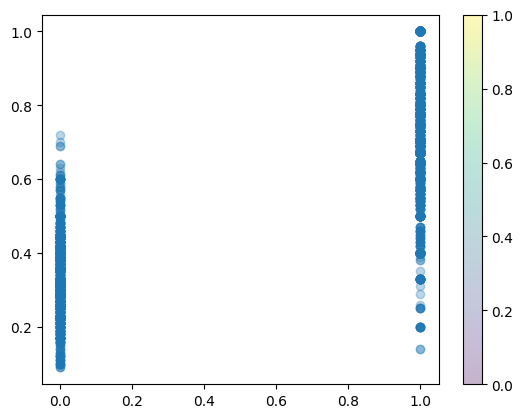

In [13]:
rng = np.random.RandomState(0)
x = df['Label'].to_list()
y = df['partial_score'].to_list()
colors = rng.rand(100)

plt.scatter(x, y, alpha=0.3, cmap='viridis')
plt.colorbar();  # show color scale

[[-1.72260566e+00 -8.11976829e-01]
 [ 9.33957549e-01 -1.61269687e-01]
 [-8.87971610e-01  2.61375145e+00]
 [ 6.18752040e-01  1.71053197e-01]
 [ 8.54479950e-02 -1.61376238e+00]
 [-1.25838141e+00 -5.67221815e-01]
 [ 1.96897748e+00 -3.53434733e+00]
 [-1.32253556e+00  2.98841693e+00]
 [-8.23818278e-01 -1.34111262e+00]
 [-1.60690273e-01  3.77632559e-01]
 [ 2.05946620e+00  3.91332914e-01]
 [ 1.65947802e-01  8.61811734e-01]
 [ 3.20490882e-01  9.14240348e-01]
 [ 1.37069241e+00 -4.71187624e-01]
 [ 1.27627448e+00  6.32391790e-01]
 [ 9.43312320e-01 -1.54946801e+00]
 [ 1.88583889e+00 -7.60216544e-02]
 [-2.14870621e+00 -3.89237400e-01]
 [-1.92688830e+00  1.97689860e+00]
 [-3.57165641e-01 -9.52898961e-01]
 [ 2.03020313e+00 -3.10812724e+00]
 [ 4.89479644e-01 -8.83315032e-01]
 [ 1.46440692e+00 -7.15607942e-01]
 [-4.75283263e-01 -1.16466095e+00]
 [-3.00843345e-03  1.70105981e+00]
 [-3.00227827e-01  1.44493406e+00]
 [-8.73869535e-01  2.47910919e+00]
 [-1.24626492e+00  5.62963333e-01]
 [-8.35283242e-01 -1

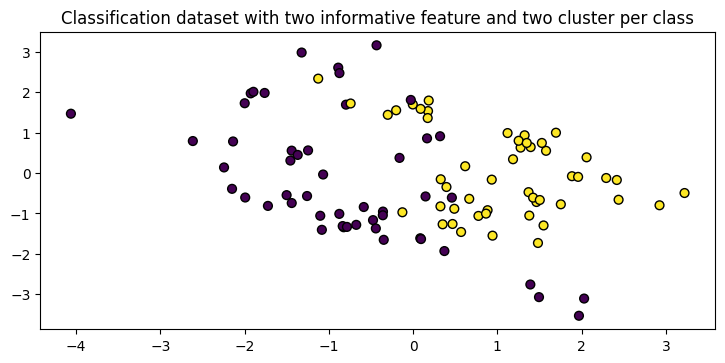

In [14]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Creating the classification dataset with two informative feature and two cluster per class
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2)
print(X)
print(y)
# Plotting the dataset
plt.figure(figsize=(7.50, 3.50))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.subplot(111)
plt.title("Classification dataset with two informative feature and two cluster per class", fontsize="12")
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=40, edgecolor="k")
plt.show()

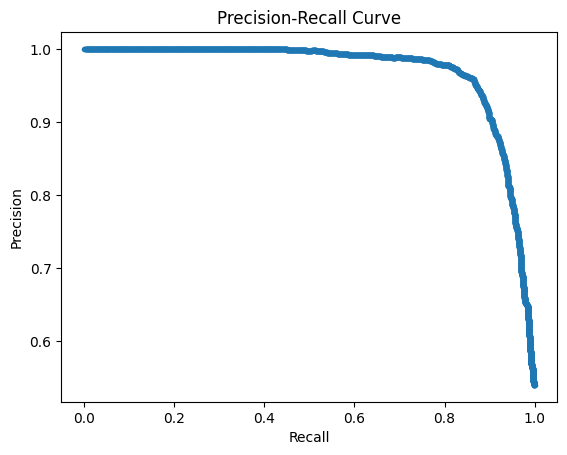

In [15]:
from sklearn.metrics import precision_recall_curve

# Assuming you have columns 'similarity_score' and 'label' in your dataset
precision, recall, thresholds = precision_recall_curve(df['Label'], df['Overall score'])

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


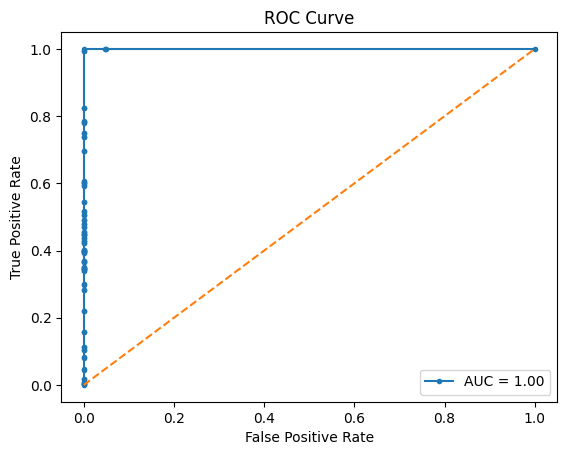

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the false positive rate, true positive rate, and thresholds
df['predicted_label'] = df['Overall score'].apply(lambda x: 1 if x >= 0.25 else 0)
fpr, tpr, _ = roc_curve(df['predicted_label'], df['Overall score'])
auc_score = roc_auc_score(df['predicted_label'], df['Overall score'])

plt.plot(fpr, tpr, marker='.', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


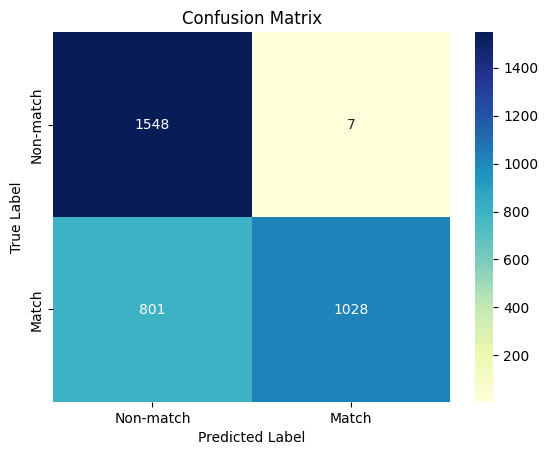

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 0.5 as a threshold; adjust as needed
df['predicted_label'] = df['Overall score'].apply(lambda x: 1 if x >= 0.5 else 0)
cm = confusion_matrix(df['Label'], df['predicted_label'])

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Non-match', 'Match'], yticklabels=['Non-match', 'Match'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Combining different algos by adjusting weights

In [ ]:
!pip install fuzzy

  Preparing metadata (setup.py) ... done
  Created wheel for fuzzy: filename=Fuzzy-1.2.2-cp310-cp310-linux_x86_64.whl size=206410 sha256=d8871fc4982450defafd07fc03747de04bf4fed487ff5acc28ed1edccf355f3b
  Stored in directory: /root/.cache/pip/wheels/3e/a7/03/cb9f418321ad60736caa7a86f0077f6ab74b669885c3e03cc1
Successfully built fuzzy


In [ ]:
import jellyfish
from fuzzy import Soundex, DMetaphone
import re
from difflib import SequenceMatcher

soundex = Soundex(4)
dmetaphone = DMetaphone()

import unicodedata

def normalize_to_ascii(text):
    # Normalize Unicode characters to ASCII
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')

def normalize_name(name):
    # Convert to lowercase and remove non-alphabetic characters
    name = normalize_to_ascii(name.lower())
    return re.sub(r'[^a-zA-Z\s]', '', name.lower()).strip()

def phonetic_encoding(name):
    # Get Soundex encoding
    soundex_code = soundex(name)
    # Get Double Metaphone encoding (returns two possible encodings)
    metaphone_code1, metaphone_code2 = dmetaphone(name)

    return soundex_code, metaphone_code1, metaphone_code2

def token_sort_ratio(name1, name2):
    sorted_name1 = " ".join(sorted(name1.split()))
    sorted_name2 = " ".join(sorted(name2.split()))
    return SequenceMatcher(None, sorted_name1, sorted_name2).ratio() * 100

def combined_similarity_score(name1, name2):
    # Step 1: Normalize names
    name1, name2 = normalize_name(name1), normalize_name(name2)

    # Step 2: Phonetic encoding for both names
    s1, m1_1, m1_2 = phonetic_encoding(name1)
    s2, m2_1, m2_2 = phonetic_encoding(name2)

    # Step 3: Token sort ratio (order-independent similarity)
    token_score = token_sort_ratio(name1, name2)

    # Step 4: Levenshtein Distance (Edit Distance)
    lev_distance = jellyfish.levenshtein_distance(name1, name2)
    lev_similarity = max(0, 100 - lev_distance)  # Normalize to 0-100 scale

    # Step 5: Jaro-Winkler similarity
    jw_similarity = jellyfish.jaro_winkler(name1, name2) * 100

    # Step 6: Phonetic similarity (if codes match, score as 100; if not, score 0)
    phonetic_score = 0
    if s1 == s2 or m1_1 == m2_1 or m1_2 == m2_2:
        phonetic_score = 100

    # Step 7: Combine scores with weighted average (adjust weights as needed)
    final_score = (0.3 * token_score + 0.3 * lev_similarity +
                   0.2 * jw_similarity + 0.2 * phonetic_score)

    return final_score

def is_name_match(name1, name2, threshold=75):
    # Calculate similarity score and compare with threshold
    score = combined_similarity_score(name1, name2)
    return score >= threshold, score

# Example usage
name1 = "Philip Charles Davis Smith"
name2 = "P. C. D. Smith"
match, score = is_name_match(name1, name2)

print(f"Names match: {match}, Score: {score:.2f}")


UnicodeDecodeError: 'ascii' codec can't decode byte 0x88 in position 0: ordinal not in range(128)